# Landmarks Detection

1. We can make a neural network output the X and Y cordinates of important points in a image, these points are known as landmarks. 
e.g. Let's consider a face recognition application and for some reason, we want the algorithm to tell us where is the corner of someone's eye. So, we can make the neural network ouput the cordinates of the begining point of the person's eye. Likewise, we can make the neural network output as many landmarks we want it to.

2. Landmark detection is really helpfull in finding wout the emoition of the face, 
e.g. if we make the neural network output some kwy points along the mouth and can extract the shape of the mouth, we can tell whether the person is smillint or frowning. 
Filters used in snapchat and instagram also use it

3. Here, first we need to build a training set, which consists of human faces and the cordinats of the landmarks  for those faces(lets say we have 30 cordinates) as labels. Then, we will have it go through a convnet and then have it output l1x, l1y and so on down to l34x, l34y.

4. Being able to detect these landmarks on the face, there's also a key building block for the computer graphics.
e.g. effects that warp the face or draw various special effects, like putting a crown or a hat on the person. 

5. Of course, in order to treat a network like this, we need a label training set. We have a set of images as well as labels Y where people, where someone will have had to go through and laboriously annotate all of these landmarks. 

6. This technique is also useful in people pose detection.

Importing the needful packages

In [16]:
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
#import cv2

from random import shuffle

import mllib

# Dataset

To train the model on landmark detection we have to create a dataset first.<br>

This dataset contains images of human faces which we will feed to the neural net and 15 landmarks on the image.<br> There are total 7049 images eah of 96*96 pixals and all of the landmarks are labeled by hand in thosse images. 

Let's see some notation:<br>
X : a set of all the images.<br>
    e.g. X[0] = first image and so on...<br>
Y : set of all the cordinates<br>
    e.g. Y[0, :] contains a list of all the landmark cordinates of the first image such that<br>
          Y[0, 0] = x1; Y[0, 1] = y1<br>
          Y[0, 3] = x2; Y[0, 4] = y2<br>
          ... ...  ... ...   ... ...<br>
          Y[0, 28] = x15; Y[0, 29] = y15<br>
          if (x1, y1) is the first landmark, (x2, y2) is the second landark and so on.<br>

## 1. Load images and landmarks into the notebook

Loading the datasets needed to memory:
We are given three CSV files

* training.csv :- Its has coordinates of facial keypoints like left eye, rigth eye etc and also the image in pixel format.

* test.csv :- Its has image only and we have to give coordinates of various facial keypoints by looking at third csv file which is IdLookupTable.csv

* IdLookupTable.csv 

In [5]:
#loading data into memory
train_data = pd.read_csv('training.csv')  
test_data = pd.read_csv('test.csv')
lookid_data = pd.read_csv('IdLookupTable.csv')

Our images in both the train and test set is stored in string format - so we write the function below to handle the image strings and convert them to a matrix.

In [6]:
def to_image(str_images):
    '''
    converts a string of ints separated by white space.
    
    args --
        str_image : numpy array of strings of ints
    return --
        image : numpy array of all the images
    '''
    images = []

    for str_image in str_images:
        image = np.array(list(map(int, str_image.split())))
        image = np.reshape(image, (96, 96))
        images.append(image)

    images =np.stack(images, 2) 
    images = np.rollaxis(images, 2)

    return images

Passing our image values in the training dataset to the function above to convert it to the required format.

In [7]:
#storing images from the training dataset in a separate variable.
images = train_data['Image'].values

images = to_image(images)

#printing the shape of image as (# of examples) * (height of the image) * (width of the image) format.
images.shape



(7049, 96, 96)

Storing all the key-points from the training dataset as 'landmarks' and dropping the 'Image' column

In [8]:
landmarks = train_data.drop(['Image'], axis=1)

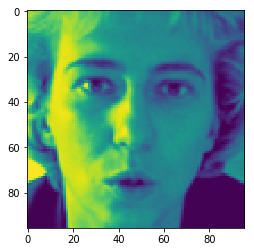

In [9]:
#plotting an image from the training dataset
plt.imshow(images[1])

Checking the tensorflow version in use

In [10]:
tf.__version__

'1.14.1-dev20190307'

## 2. Exploratory Data Analysis

Perform EDA to preprocess the dataset and make it fit for training and also to get a hold on the dataset

### 2.1. Check the dimensions of the images and reshape them in (# of examples) * (height of the image) * (width of the image)

In [11]:
# check shape of the dataset
print('Shape of training dataset :', images.shape)

Shape of training dataset : (7049, 96, 96)


In [12]:
# change the data shape to m, w, h
#images = images.swapaxes(0,2).swapaxes(1,2)
print('Shape of training dataset ofter changing :', images.shape)
m, w0, h0 = images.shape

Shape of training dataset ofter changing : (7049, 96, 96)


### 2.2. Plot some images

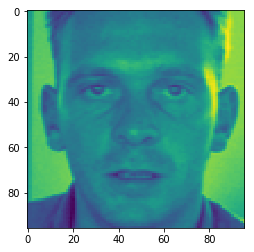

In [13]:
# lets see the first image of the datasset
plt.imshow(images[2])

In [14]:
# lets print the image
images[0]

array([[238, 236, 237, ..., 250, 250, 250],
       [235, 238, 236, ..., 249, 250, 251],
       [237, 236, 237, ..., 251, 251, 250],
       ...,
       [186, 183, 181, ...,  52,  57,  60],
       [189, 188, 207, ...,  61,  69,  78],
       [191, 184, 184, ...,  70,  75,  90]])

### 2.3. Normalize the dataset by dividing it by 255 for faster convergenvce as gradient descent runs faster on normalised dataset

In [15]:
X_data = images / 255

In [16]:
#plotting one obeservation from the normalised image data
X_data[0]

array([[0.93333333, 0.9254902 , 0.92941176, ..., 0.98039216, 0.98039216,
        0.98039216],
       [0.92156863, 0.93333333, 0.9254902 , ..., 0.97647059, 0.98039216,
        0.98431373],
       [0.92941176, 0.9254902 , 0.92941176, ..., 0.98431373, 0.98431373,
        0.98039216],
       ...,
       [0.72941176, 0.71764706, 0.70980392, ..., 0.20392157, 0.22352941,
        0.23529412],
       [0.74117647, 0.7372549 , 0.81176471, ..., 0.23921569, 0.27058824,
        0.30588235],
       [0.74901961, 0.72156863, 0.72156863, ..., 0.2745098 , 0.29411765,
        0.35294118]])

### 2.4. Add a new axis for channels

In [17]:
# reshape X_data to add channel 
X_data = X_data[:, :, :, np.newaxis]
m, w0, h0, c0 = X_data.shape

### 2.5. Let's see the landmaks dataset

In [18]:
# print the landmarks
landmarks.head().T

,0,1,2,3,4
left_eye_center_x,66.033564,64.332936,65.057053,65.225739,66.725301
left_eye_center_y,39.002274,34.970077,34.909642,37.261774,39.621261
right_eye_center_x,30.227008,29.949277,30.903789,32.023096,32.244810
right_eye_center_y,36.421678,33.448715,34.909642,37.261774,38.042032
left_eye_inner_corner_x,59.582075,58.856170,59.412000,60.003339,58.565890
left_eye_inner_corner_y,39.647423,35.274349,36.320968,39.127179,39.621261
left_eye_outer_corner_x,73.130346,70.722723,70.984421,72.314713,72.515926
left_eye_outer_corner_y,39.969997,36.187166,36.320968,38.380967,39.884466
right_eye_inner_corner_x,36.356571,36.034723,37.678105,37.618643,36.982380
right_eye_inner_corner_y,37.389402,34.361532,36.320968,38.754115,39.094852


Store the landmarks in a numpy array and checking the shape

In [19]:
Y_data = landmarks.values
Y_data.shape

(7049, 30)

In [20]:
# print the shape of the landmarks
print('shape of landmark labels :', Y_data.shape)

shape of landmark labels : (7049, 30)


### 2.6. Clean nan valus present in landmark dataset (if any)

In [21]:
print('Q. Is there any nan entries present in the dataset?\nA.', np.isnan(Y_data).any())

Q. Is there any nan entries present in the dataset?
A. True


Lets draw images with landmarks containing missing values

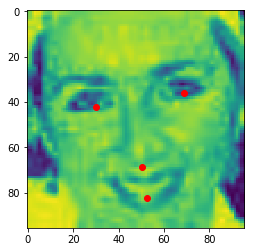

In [22]:
n = 6095

# Separate x and y axes cords into different lists
cord_x = []
cord_y = []
for i in range(15):
    cord_x.append(Y_data[n, 2*i])
    cord_y.append(Y_data[n, 2*i + 1])
    
plt.imshow(images[n])
plt.scatter(cord_x, cord_y, color='red')

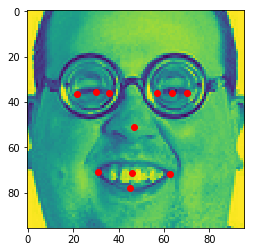

In [23]:
n = 1636

# Separate x and y axes cords into different lists
cord_x = []
cord_y = []
for i in range(15):
    cord_x.append(Y_data[n, 2*i])
    cord_y.append(Y_data[n, 2*i + 1])
    
plt.imshow(images[n])
plt.scatter(cord_x, cord_y, color='red')

As Replace all the nan values with mean of the column having 'non-nan' values.

In [24]:
# store all the nan indeces in a list
nan_idx = tuple(np.argwhere(np.isnan(Y_data)).T)

# repalce all the nan values with 0 and then calculate mean
# Y_data[nan_idx] = 0
mean = np.nanmean(Y_data, axis=0)

In [25]:
mean

array([66.35902124, 37.65123419, 30.30610151, 37.97694257, 59.15933944,
       37.94475233, 73.33047798, 37.70700831, 36.65260695, 37.98990191,
       22.38450448, 38.03349518, 56.06851308, 29.33267825, 79.48282586,
       29.73486073, 39.32213692, 29.50299847, 15.87117747, 30.42816591,
       48.37418629, 62.7158836 , 63.28573512, 75.97071434, 32.9004037 ,
       76.17976785, 47.97541157, 72.9194426 , 48.56947217, 78.97014625])

In [26]:
# replace nan values with mean
Y_data[nan_idx] = mean[nan_idx[1]]

Lets draw images with landmarks after eliminating nan values

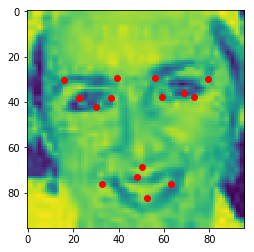

In [27]:
n = 6095

# Separate x and y axes cords into different lists
cord_x = []
cord_y = []
for i in range(15):
    cord_x.append(Y_data[n, 2*i])
    cord_y.append(Y_data[n, 2*i + 1])
    
plt.imshow(images[n])
plt.scatter(cord_x, cord_y, color='red')

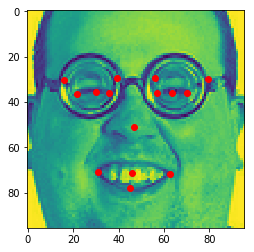

In [28]:
n = 1636

# Separate x and y axes cords into different lists
cord_x = []
cord_y = []
for i in range(15):
    cord_x.append(Y_data[n, 2*i])
    cord_y.append(Y_data[n, 2*i + 1])
    
plt.imshow(images[n])
plt.scatter(cord_x, cord_y, color='red')

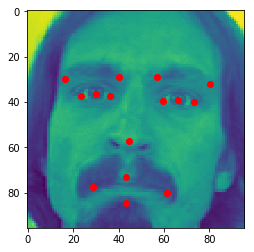

In [29]:
n = 0

# Separate x and y axes cords into different lists
cord_x = []
cord_y = []
for i in range(15):
    cord_x.append(Y_data[n, 2*i])
    cord_y.append(Y_data[n, 2*i + 1])
    
plt.imshow(images[n])
plt.scatter(cord_x, cord_y, color='red')

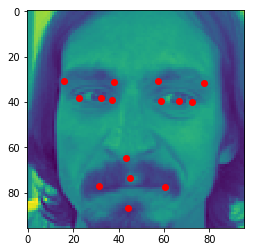

In [30]:
n = 4

# Separate x and y axes cords into different lists
cord_x = []
cord_y = []
for i in range(15):
    cord_x.append(Y_data[n, 2*i])
    cord_y.append(Y_data[n, 2*i + 1])
    
plt.imshow(images[n])
plt.scatter(cord_x, cord_y, color='red')

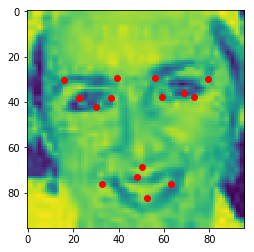

In [31]:
n = 6095

# Separate x and y axes cords into different lists
cord_x = []
cord_y = []
for i in range(15):
    cord_x.append(Y_data[n, 2*i])
    cord_y.append(Y_data[n, 2*i + 1])
    
plt.imshow(images[n])
plt.scatter(cord_x, cord_y, color='red')

In [32]:
print('cord x =', cord_x)
print('cord y =', cord_y)

cord x = [68.7496186047, 29.8944, 59.15933943740387, 73.3304779831461, 36.65260694805725, 22.384504479169358, 56.06851307930929, 79.48282586419953, 39.32213692201748, 15.871177472719152, 50.225637209300004, 63.285735120986686, 32.90040370265762, 47.9754115720203, 52.71047441859999]
cord y = [36.1527293023, 42.0261655814, 37.94475232796772, 37.707008310792986, 37.98990191451049, 38.033495175250536, 29.332678249311716, 29.734860732432317, 29.502998474113003, 30.428165911873432, 68.4566176744, 75.97071433583544, 76.17976785460499, 72.91944259683736, 82.2365916279]


### 2.7. Plot some images to get hold of the data distribution

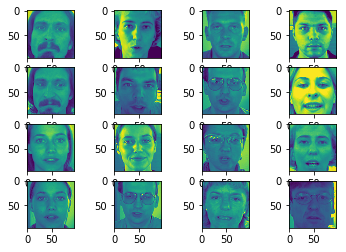

In [33]:
grid = 4

_, ax = plt.subplots(grid, grid)


for i in range(grid):
    for j in range(grid):
        if grid*i + j < m:
            ax[i, j].imshow(images[grid*i + j])
        else:
            break

## 3. split the data set into train, validation and test sets

We will shuffle the data and split it randomly. We will perform a 80%, 20%, split for train and validation <br>

We will train our model on the training set.<br>
Then we will tune the hyperparameters like learning rate, regulralization parameter, batch size etc. on the validation set.<br>
Finally we will measure the perfomance of the model in the test set.

In [34]:
# list of indeces of each example
idx = list(range(0, m))
shuffle(idx)

train_idx = idx[:int(m*80/100)]
val_idx = idx[int(m*80/100) : ]
#test_idx = idx[int(m*85/100):]

In [35]:
X_train = X_data[train_idx, :, :]
Y_train = Y_data[train_idx, :]
X_val = X_data[val_idx, :, :]
Y_val = Y_data[val_idx, :]
#X_test = X_data[test_idx, :, :]
#Y_test = Y_data[test_idx, :]

# Modeling Phase

## Zero-Padding

Zero-padding adds zeros around the border of an image:

<img src="images/PAD.png" style="width:600px;height:400px;">
<caption><center> <u> <font color='purple'> **Figure 1** </u><font color='purple'>  : **Zero-Padding**<br> Image (3 channels, RGB) with a padding of 2. </center></caption>

The main benefits of padding are the following:

- It allows you to use a CONV layer without necessarily shrinking the height and width of the volumes. This is important for building deeper networks, since otherwise the height/width would shrink as you go to deeper layers. An important special case is the "same" convolution, in which the height/width is exactly preserved after one layer. 

- It helps us keep more of the information at the border of an image. Without padding, very few values at the next layer would be affected by pixels as the edges of an image.

## Convolutional Neural Networks

Although programming frameworks make convolutions easy to use, they remain one of the hardest concepts to understand in Deep Learning. A convolution layer transforms an input volume into an output volume of different size, as shown below. 
<img src="images/conv_nn.png" style="width:350px;height:200px;">

## Single step of convolution 

This part shows a single step of convolution, in which you apply the filter to a single position of the input. This will be used to build a convolutional unit, which: 

- Takes an input volume 
- Applies a filter at every position of the input
- Outputs another volume (usually of different size)

<img src="images/Convolution_schematic.gif" style="width:500px;height:300px;">
<caption><center> <u> <font color='purple'> **Figure 2** </u><font color='purple'>  : **Convolution operation**<br> with a filter of 2x2 and a stride of 1 (stride = amount you move the window each time you slide) </center></caption>

In a computer vision application, each value in the matrix on the left corresponds to a single pixel value, and we convolve a 3x3 filter with the image by multiplying its values element-wise with the original matrix, then summing them up. 

## Convolutional Neural Networks - Forward pass

In the forward pass, you will take many filters and convolve them on the input. Each 'convolution' gives you a 2D matrix output. You will then stack these outputs to get a 3D volume: 


<img src="images/vert_horiz_kiank.png" style="width:400px;height:300px;">



**Reminder**:
The formulas relating the output shape of the convolution to the input shape is:
$$ n_H = \lfloor \frac{n_{H_{prev}} - f + 2 \times pad}{stride} \rfloor +1 $$
$$ n_W = \lfloor \frac{n_{W_{prev}} - f + 2 \times pad}{stride} \rfloor +1 $$
$$ n_C = \text{number of filters used in the convolution}$$

where, n_H = hight of the output<br>
n_W = width of the output<br>
n_C = number of output channels<br>
n_H_prev = height of the privious layer<br>
n_W_prev = width of the previous layer<br>
n_C_prev = number of channels in the previous layer<br>
pad = number of padding units<br>
stride = stride of convolution

## Pooling layer 

The pooling (POOL) layer reduces the height and width of the input. It helps reduce computation, as well as helps make feature detectors more invariant to its position in the input. The two types of pooling layers are: 

- Max-pooling layer: slides an ($f, f$) window over the input and stores the max value of the window in the output.

- Average-pooling layer: slides an ($f, f$) window over the input and stores the average value of the window in the output.

<table>
<td>
<img src="images/max_pool1.png" style="width:500px;height:300px;">
<td>

<td>
<img src="images/a_pool.png" style="width:500px;height:300px;">
<td>
</table>

These pooling layers have no parameters for backpropagation to train. However, they have hyperparameters such as the window size $f$. This specifies the height and width of the fxf window you would compute a max or average over. 

## Forward Pooling

**Reminder**:
As there's no padding, the formulas binding the output shape of the pooling to the input shape is:
$$ n_H = \lfloor \frac{n_{H_{prev}} - f}{stride} \rfloor +1 $$
$$ n_W = \lfloor \frac{n_{W_{prev}} - f}{stride} \rfloor +1 $$
$$ n_C = n_{C_{prev}}$$

## Backpropagation in convolutional neural networks

In modern deep learning frameworks, we only have to implement the forward pass, and the framework takes care of the backward pass, so most deep learning engineers don't need to bother with the details of the backward pass. The backward pass for convolutional networks is complicated. 

###  Convolutional layer backward pass 

Let's start by implementing the backward pass for a CONV layer. 

####  Computing dA:
This is the formula for computing $dA$ with respect to the cost for a certain filter $W_c$ and a given training example:

$$ dA += \sum _{h=0} ^{n_H} \sum_{w=0} ^{n_W} W_c \times dZ_{hw} \tag{1}$$

Where $W_c$ is a filter and $dZ_{hw}$ is a scalar corresponding to the gradient of the cost with respect to the output of the conv layer Z at the hth row and wth column (corresponding to the dot product taken at the ith stride left and jth stride down). Note that at each time, we multiply the the same filter $W_c$ by a different dZ when updating dA. We do so mainly because when computing the forward propagation, each filter is dotted and summed by a different a_slice. Therefore when computing the backprop for dA, we are just adding the gradients of all the a_slices. 


#### Computing dW:
This is the formula for computing $dW_c$ ($dW_c$ is the derivative of one filter) with respect to the loss:

$$ dW_c  += \sum _{h=0} ^{n_H} \sum_{w=0} ^ {n_W} a_{slice} \times dZ_{hw}  \tag{2}$$

Where $a_{slice}$ corresponds to the slice which was used to generate the acitivation $Z_{ij}$. Hence, this ends up giving us the gradient for $W$ with respect to that slice. Since it is the same $W$, we will just add up all such gradients to get $dW$. 


####  Computing db:

This is the formula for computing $db$ with respect to the cost for a certain filter $W_c$:

$$ db = \sum_h \sum_w dZ_{hw} \tag{3}$$

In basic neural networks, db is computed by summing $dZ$. In this case, you are just summing over all the gradients of the conv output (Z) with respect to the cost.

## Pooling layer - backward pass

Next, let's see the backward pass for the pooling layer, starting with the MAX-POOL layer. Even though a pooling layer has no parameters for backprop to update, you still need to backpropagation the gradient through the pooling layer in order to compute gradients for layers that came before the pooling layer. 

### Max pooling - backward pass  

Before jumping into the backpropagation of the pooling layer, you are going to build a helper function called `create_mask_from_window()` which does the following: 

$$ X = \begin{bmatrix}
1 && 3 \\
4 && 2
\end{bmatrix} \quad \rightarrow  \quad M =\begin{bmatrix}
0 && 0 \\
1 && 0
\end{bmatrix}\tag{4}$$

As you can see, this function creates a "mask" matrix which keeps track of where the maximum of the matrix is. True (1) indicates the position of the maximum in X, the other entries are False (0). You'll see later that the backward pass for average pooling will be similar to this but using a different mask.  

Why do we keep track of the position of the max? It's because this is the input value that ultimately influenced the output, and therefore the cost. Backprop is computing gradients with respect to the cost, so anything that influences the ultimate cost should have a non-zero gradient. So, backprop will "propagate" the gradient back to this particular input value that had influenced the cost. 

### Average pooling - backward pass 

In max pooling, for each input window, all the "influence" on the output came from a single input value--the max. In average pooling, every element of the input window has equal influence on the output. So to implement backprop, you will now implement a helper function that reflects this.

For example if we did average pooling in the forward pass using a 2x2 filter, then the mask you'll use for the backward pass will look like: 
$$ dZ = 1 \quad \rightarrow  \quad dZ =\begin{bmatrix}
1/4 && 1/4 \\
1/4 && 1/4
\end{bmatrix}\tag{5}$$

This implies that each position in the $dZ$ matrix contributes equally to output because in the forward pass, we took an average. 

## Baseline Model

We will use a baseline model consisting of 6 layers, viz - This model consists of 6 layers, viz - 2 convolution layers followed by 2 pooling layers respectively, we will add 1 fully connected layers to it and finally one output layer.
<br>
So the model will look something like this<br>
CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED -> OUTPUT

## Final Model

For our final model, we implemented the forward_propagation function below to build the following model: 
We will use a model consisting of 13 layer, viz - 5 convolution layers followed by 5 pooling layers respectively, we will add 2 fully connected layers to it and finally one output layer.<br>
So the model will look something like this<br>
CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED -> DROPOUT REGULARIZATION -> OUTPUT.


<img src="images/model.png" style="width:800px;height:300px;">

**Note** the above picture shows a simple model

# 4. Getting Started

To get started, let's examine the shapes of your data.

In [36]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of validation examples = " + str(X_val.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_val shape: " + str(X_val.shape))
print ("Y_val shape: " + str(Y_val.shape))
#print ("X_test shape: " + str(X_test.shape))
#print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 5639
number of validation examples = 1410
X_train shape: (5639, 96, 96, 1)
Y_train shape: (5639, 30)
X_val shape: (1410, 96, 96, 1)
Y_val shape: (1410, 30)


### 4.1. Create placeholders

TensorFlow requires that you create placeholders for the input data that will be fed into the model when running the session.

The function below creates placeholders for the input image X and the output Y. We should not define the number of training examples for the moment. To do so, you could use "None" as the batch size, it will give you the flexibility to choose it later. Hence X should be of dimension **[None, n_H0, n_W0, n_C0]** and Y should be of dimension **[None, n_y]**

In [37]:
def create_placeholder(n_H0, n_W0, n_C0, n_Y):
    '''
    Creates the placeholders for the tensorflow session
    
    Arguments :
    n_H0 -- scalar, height of an input inage
    n_W0 -- scalar, width of an input image
    n_C0 -- scalar, number of channels of the input
    n_y -- scalar, number of cordines
    
    Returns:
    X -- placeholder for the input data of shape [None, n_H0, n_W0, n_C0] and dtype "float"
    Y -- placeholder for the input landmark of shape [None, n_y]
    '''
    
    X = tf.placeholder(tf.float32, [None, n_H0, n_W0, n_C0])
    Y = tf.placeholder(tf.float32, [None, n_Y])
    
    return X, Y

### 4.2. Initialize parameters

We will initialize weights/filters $W1$ and $W2$ using `tf.contrib.layers.xavier_initializer(seed = 0)`. We don't need to worry about bias variables as TensorFlow functions take care of the bias. Note also that we will only initialize the weights/filters for the conv2d functions. TensorFlow initializes the weights for the fully connected part automatically. We will talk more about that later in this assignment.

In [38]:
def initialize_parameters(parameter_dims = [[4, 4, 1, 4], [4, 4, 4, 16],
                                           [2, 2, 16, 32], [2, 2, 32, 16]], pretrained_values = None):
    '''
    Initializes weight parameters to build a neural network with tensorfloe. The default shapes are:
                W1 : [4, 4, 1, 4]
                W2 : [4, 4, 4, 16]
                W3 : [2, 2, 16, 32]
                W4 : [2, 2, 32, 16]
    Arguments :
    parameter_dims -- list containing the dimenssions of the weight matrics
    pretrained_values -- dictonary containing pretrained parameter values, if given it copies its values
    current parameters
                
    Returns:
    parameters --  a dictionary of tensors containing W1, W2, W3, W4
    '''
    
    parameters = {}
    
    if pretrained_values == None:
        for i, parameter_dim in enumerate(parameter_dims):
            parameters['W' + str(i+1)] = tf.get_variable('W' + str(i+1), parameter_dim, 
                                                     initializer=tf.contrib.layers.xavier_initializer())
    else:
        for i, parameter_dim in enumerate(parameter_dims):
            parameters['W' + str(i+1)] = tf.Variable(pretrained_values['W' + str(i+1)], 'W' + str(i+1))
    
    return parameters

### 4.3. Forward propagation

In TensorFlow, there are built-in functions that carry out the convolution steps for us.

- **tf.nn.conv2d(X,W1, strides = [1,s,s,1], padding = 'SAME'):** given an input $X$ and a group of filters $W1$, this function convolves $W1$'s filters on X. The third input ([1,f,f,1]) represents the strides for each dimension of the input (m, n_H_prev, n_W_prev, n_C_prev). You can read the full documentation [here](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d)

- **tf.nn.max_pool(A, ksize = [1,f,f,1], strides = [1,s,s,1], padding = 'SAME'):** given an input A, this function uses a window of size (f, f) and strides of size (s, s) to carry out max pooling over each window. You can read the full documentation [here](https://www.tensorflow.org/api_docs/python/tf/nn/max_pool)

- **tf.nn.relu(Z1):** computes the elementwise ReLU of Z1 (which can be any shape). You can read the full documentation [here.](https://www.tensorflow.org/api_docs/python/tf/nn/relu)

- **tf.contrib.layers.flatten(P)**: given an input P, this function flattens each example into a 1D vector it while maintaining the batch-size. It returns a flattened tensor with shape [batch_size, k]. You can read the full documentation [here.](https://www.tensorflow.org/api_docs/python/tf/contrib/layers/flatten)

- **tf.contrib.layers.fully_connected(F, num_outputs):** given a the flattened input F, it returns the output computed using a fully connected layer. You can read the full documentation [here.](https://www.tensorflow.org/api_docs/python/tf/contrib/layers/fully_connected)

In the last function above (`tf.contrib.layers.fully_connected`), the fully connected layer automatically initializes weights in the graph and keeps on training them as you train the model. Hence, you did not need to initialize those weights when initializing the parameters. 


We will Implement the `forward_propagation` function below to build the following model: `CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED -> DROPOUT REGULARIZATION -> OUTPUT`. You should use the functions above. 

In detail, we will use the following parameters for all the steps:
     - Conv2D: stride 1, padding is "SAME"
     - ReLU
     - Max pool: Use an 8 by 8 filter size and an 8 by 8 stride, padding is "SAME"
     - Conv2D: stride 1, padding is "SAME"
     - ReLU
     - Max pool: Use a 4 by 4 filter size and a 4 by 4 stride, padding is "SAME"
     - Flatten the previous output.
     - FULLYCONNECTED (FC) layer: we will apply a fully connected layer without an non-linear activation function

In [39]:
def forward_propagation(X, parameters, n_Y=30, pool_frequency = 1, keep_prob = None):
    '''
    Implements the forward propagation for the model:
    e.g. CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
        X -- input dataset placeholder, of shape (input size, number of examples)
        parameters -- python dictionary containing your parameters "W1", "W2"
                  the shapes are given in initialize_parameters
        n_Y -- int, numbers of ladmarks
        pool_frequency -- no. of convolution layers between 2 pooling layers
        keep_prob -- if None :: no regularization, else holds the dropout probability

    Returns:
        Z_final -- the output of the last LINEAR unit
    '''
    i = 1
    # CONV2D: stride of 1, padding 'SAME'
    Z = tf.nn.conv2d(X, parameters['W1'], strides=[1, 1, 1, 1], padding='SAME', name='CONV2D'+'W1')
    # RELU
    A = tf.nn.relu(Z, name='relu'+'W1')
    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    if pool_frequency == 1:
        P = tf.nn.max_pool(A, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding='SAME', name='pool'+'W1')
    else:
        P = A
    
    for weight, parameter in parameters.items():
        i += 1
        # pass the first loop
        if weight == 'W1':
            continue
        # CONV2D: stride of 1, padding 'SAME'
        Z = tf.nn.conv2d(P, parameter, strides=[1, 1, 1, 1], padding='SAME', name='CONV2D'+weight)
        # RELU
        A = tf.nn.relu(Z, name='relu'+weight)
        # MAXPOOL: window 4x4, stride 4, padding 'SAME'
        if i % pool_frequency == 0:
            P = tf.nn.max_pool(A, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding='SAME', name='pool'+weight)
        else:
            P = A
            
        
    # FLATTEN
    P = tf.contrib.layers.flatten(P)
    # DROUPOUT REGULARIZATION
    if keep_prob != None:
        P = tf.nn.dropout(P, rate=1-keep_prob)
    # FULLY-CONNECTED without non-linear activation function (not not call softmax).
    Z = tf.contrib.layers.fully_connected(P, 1024, activation_fn=tf.nn.relu)
    # n_Y neurons in output layer 
    Z_final = tf.contrib.layers.fully_connected(Z, n_Y, activation_fn=None)

    return Z_final

### 4.4. Cost function

We will implement the compute cost function below.<br>

We will use simmple squared error cost function for this task. <br>

Assumption : Every observation is independant of each other.

In [40]:
# cost function
def compute_cost(Z_final, Y):
    '''
    Computes the cost
    
    Arguments:
    Z_final -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    '''
    cost = tf.losses.mean_squared_error(Y, Z_final)
    # cost = tf.reduce_sum(tf.square(Y - Z_final))
    #cost = Y - Z_final
    
    return cost

### 4.5. Build the tensorflow graph for the model

Finally we will merge the helper functions implemented above to build a model. 

The model below should:

- create placeholders
- initialize parameters
- forward propagate
- compute the cost
- create an optimizer

We will use the adam optimizer for faster convergence

In [41]:
def model_graph(X_train, Y_train, parameter_dims = [[3, 3, 3, 8], [2, 2, 8, 16]], pool_frequency = 1, 
                learning_rate=0.003, keep_prob=None, n_Y=30):
    """
    Creates tensorflow graph for the model
    e.g : CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X_train -- training set, of shape (None, 64, 64, 3)
    Y_train -- test set, of shape (None, n_y = 6)
    parameter_dims -- list of dimenssions of the weights
    pool_frequency -- no. of convolution layers between 2 pooling layers
    learning_rate -- learning rate of the optimization
    
    Returns:
    X -- placeholder for input data
    Y -- placeholder for true landmarks
    parameters -- a dictionary of tensors containing initiallized parameters
    Z_final -- predicted landmarks
    cost -- cost of the model
    optimizer -- adam optimizer
    learning_rate -- learnning rate of the model
    init -- tensorflow variable initializer
    
    """

    # run the graph without overwritting the variables
    tf.reset_default_graph()
    
    # store the dimenssions of the training set
    (m, n_H0, n_W0, n_C0) = X_train.shape 
    n_Y = Y_train.shape[1]                            
    
    # Create Placeholders of the correct shape
    X, Y = create_placeholder(n_H0, n_W0, n_C0, n_Y)
    
    # Initialize parameters
    parameters = initialize_parameters(parameter_dims)
        
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z_final = forward_propagation(X, parameters, n_Y, pool_frequency, keep_prob)
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z_final, Y)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer that minimizes the cost.
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    return X, Y, parameters, Z_final, cost, optimizer, learning_rate

### 4.6. Train the model

Finally we will create a session and run a for loop  for num_epochs, get the mini-batches, and then for each mini-batch you will optimize the function.

In [78]:
def minimize_model(X_train, Y_train, X_val, Y_val, graph, sess, num_epochs=100, minibatch_size=64, 
                   print_cost=True, X_test=np.array([None]), Y_test=None):
    """
    Implements a three-layer ConvNet in Tensorflow:
    e.g : CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X_train -- training set, of shape (None, 64, 64, 3)
    Y_train -- test set, of shape (None, n_y = 6)
    X_test -- training set, of shape (None, 64, 64, 3) or None
    Y_test -- test set, of shape (None, n_y = 6) or None
    graph -- a list containing all the outputs of model_graph in order
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    Y_val_pred -- predicted lebels for the validation set
    Y_val_test -- predicted lebels for the test set
    """
    
    # store the dimenssions of the training set
    (m, n_H0, n_W0, n_C0) = X_train.shape
    
    costs = []
    
    # unroll graph
    X = graph[0]
    Y = graph[1]
    parameters = graph[2]
    Z_final = graph[3]
    cost = graph[4]
    optimizer = graph[5]
    learning_rate = graph[6]
    
    # Do the training loop
    for epoch in range(num_epochs):
        minibatch_cost = 0
        
        # number of minibatches of size minibatch_size in the train set
        num_minibatches = int(m / minibatch_size)
            
        # divide the training set into 'num_minibatches' minibatches
        minibatches = mllib.random_mini_batches(X_train, Y_train, minibatch_size)
            
        # iterate over the minibaches
        for minibatch in minibatches:
            # Select a minibatch
            (minibatch_X, minibatch_Y) = minibatch
                
            # Run the session to execute the optimizer and the cost, the feedict should contain a 
            # minibatch for (X,Y). (Run the graph of a single minibatch)
            _ , temp_cost = sess.run([optimizer, cost], feed_dict={X:minibatch_X, Y:minibatch_Y})
            # temp_cost = sess.run(cost, feed_dict={X:minibatch_X, Y:minibatch_Y})
                
            # update minibatch cost
            minibatch_cost += temp_cost / num_minibatches
            
            # Print the cost every 5 epochs
        if print_cost == True :
            costs.append(minibatch_cost)
            if epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
                    
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    #Computing the validation cost and storing the results as 'Y_val_pred'
    print()
    Y_val_pred, val_cost = sess.run([Z_final, cost], feed_dict={X:X_val, Y:Y_val})
    print('Validation cost =', val_cost)
    
    #Computing the test cost and storing the results as 'Y_test_pred'
    Y_test_pred = None
    if X_test.any() != None: # and Y_test != None:
        Y_test_pred = sess.run(Z_final, feed_dict={X:X_test})
        # Y_test_pred, test_cost = sess.run([Z_final, cost], feed_dict={X:X_test, Y:Y_test})
        # print('Test cost =', test_cost)
                
    return  parameters, Y_val_pred, Y_test_pred

In [43]:
graph = model_graph(X_train, Y_train, parameter_dims = [[4, 4, 1, 4], [4, 4, 4, 16],
                                           [2, 2, 16, 32], [2, 2, 32, 64], [2, 2, 64, 128]], 
                    pool_frequency = 1,    
                    learning_rate=0.1,
                   )

W0421 22:40:52.757364 140712417724224 deprecation.py:323] From /home/saket/ml_env/lib/python3.6/site-packages/tensorflow/contrib/layers/python/layers/layers.py:1624: flatten (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.flatten instead.
W0421 22:40:52.907564 140712417724224 deprecation.py:506] From /home/saket/ml_env/lib/python3.6/site-packages/tensorflow/python/training/slot_creator.py:187: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



### 4.7. Create a session to train the model

Cost after epoch 0: 5582641.820280
Cost after epoch 5: 6.701166
Cost after epoch 10: 6.701166


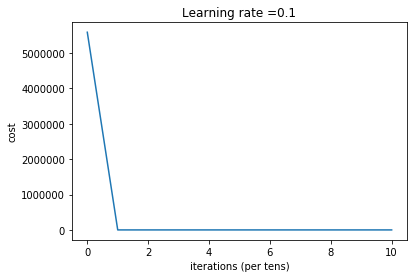


Validation cost = 25.843727


In [44]:
# Initialize all the variables globally
init = tf.global_variables_initializer()

# start the session
sess = tf.Session()

# Run the initialization
sess.run(init)

# run the model train the parameters
parameter, Y_val_pred, Y_test_pred = minimize_model(X_train, Y_train, X_val, Y_val,
                           graph, sess, num_epochs=11, minibatch_size=32, print_cost=True)

# close the session
sess.close()

## 5. Hyperparameter tunning

Now that our model is trained and we have the optimized parameters, we will test its perfomance on the validation set.<br>
We will try and test with different values of the learning_rate, minibatch_size, keep_prob and observe the metric in each of the case.<br>
Finally we will consider the model wihich will perform best on the validation set and then we will test it on the test set.

### 5.1. Let's see some results in the validation set

Plot predicted landmarks and labeled landmarks of the same image

1.predicted landmarks vs 2.labeled landmarks


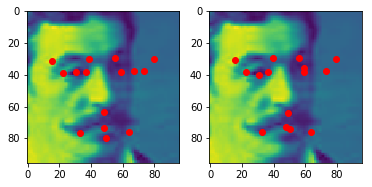

In [50]:
n1 = 205
n2 = val_idx[n1]

# Separate x and y axes cords into different lists
cord_x_pred = []
cord_y_pred = []
cord_x = []
cord_y = []

for i in range(15):
    cord_x_pred.append(Y_val_pred[n1, 2*i])
    cord_y_pred.append(Y_val_pred[n1, 2*i + 1])
    cord_x.append(Y_val[n1, 2*i])
    cord_y.append(Y_val[n1, 2*i + 1])
    
_, ax = plt.subplots(1, 2)

## plot predicted landmarks
ax[0].imshow(images[n2])
ax[0].scatter(cord_x_pred, cord_y_pred, color='red')

# plot labeled landmarks
ax[1].imshow(images[n1])
ax[1].scatter(cord_x, cord_y, color='red')
print('1.predicted landmarks vs 2.labeled landmarks')

1.predicted landmarks vs 2.labeled landmarks


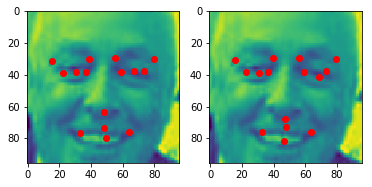

In [51]:
n1 = 0
n2 = val_idx[n1]

# Separate x and y axes cords into different lists
cord_x_pred = []
cord_y_pred = []
cord_x = []
cord_y = []

for i in range(15):
    cord_x_pred.append(Y_val_pred[n1, 2*i])
    cord_y_pred.append(Y_val_pred[n1, 2*i + 1])
    cord_x.append(Y_val[n1, 2*i])
    cord_y.append(Y_val[n1, 2*i + 1])
    
_, ax = plt.subplots(1, 2)

## plot predicted landmarks
ax[0].imshow(images[n2])
ax[0].scatter(cord_x_pred, cord_y_pred, color='red')

# plot labeled landmarks
ax[1].imshow(images[n2])
ax[1].scatter(cord_x, cord_y, color='red')
print('1.predicted landmarks vs 2.labeled landmarks')

Lets tune the hyperpamaters to get better results on validation set change the learning rate to 0.3

In [47]:
graph = model_graph(X_train, Y_train, parameter_dims = [[4, 4, 1, 4], [4, 4, 4, 16],
                                           [2, 2, 16, 32], [2, 2, 32, 64], [2, 2, 64, 128]], 
                                                                             pool_frequency = 1,
                                                                             learning_rate=0.3)

Cost after epoch 0: 1507465192780345.750000
Cost after epoch 5: 6.701166
Cost after epoch 10: 6.701166


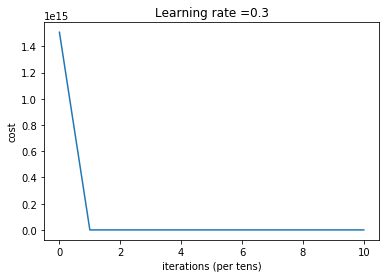


Validation cost = 7.658823


In [48]:
# Initialize all the variables globally
init = tf.global_variables_initializer()

# start the session
sess = tf.Session()

# Run the initialization
sess.run(init)

# run the model train the parameters
parameter, Y_val_pred, Y_test_pred = minimize_model(X_train, Y_train, X_val, Y_val,
                           graph, sess, num_epochs=11, minibatch_size=32, print_cost=True)

# close the session
sess.close()

1.predicted landmarks vs 2.labeled landmarks


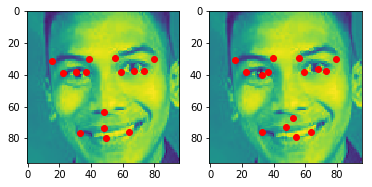

In [52]:
n1 = 105
n2 = val_idx[n1]

# Separate x and y axes cords into different lists
cord_x_pred = []
cord_y_pred = []
cord_x = []
cord_y = []

for i in range(15):
    cord_x_pred.append(Y_val_pred[n1, 2*i])
    cord_y_pred.append(Y_val_pred[n1, 2*i + 1])
    cord_x.append(Y_val[n1, 2*i])
    cord_y.append(Y_val[n1, 2*i + 1])
    
_, ax = plt.subplots(1, 2)

## plot predicted landmarks
ax[0].imshow(images[n2])
ax[0].scatter(cord_x_pred, cord_y_pred, color='red')

# plot labeled landmarks
ax[1].imshow(images[n2])
ax[1].scatter(cord_x, cord_y, color='red')
print('1.predicted landmarks vs 2.labeled landmarks')

As changing learning rate has no effect to the validation cost lets build the network 1 layer deep

In [53]:
graph = model_graph(X_train, Y_train, parameter_dims = [[4, 4, 1, 4], [4, 4, 4, 16],
                                           [2, 2, 16, 32], [2, 2, 32, 64], [2, 2, 64, 128], [2, 2, 128, 256]], 
                                                                             pool_frequency = 1,
                                                                             learning_rate=0.3)

Cost after epoch 0: 6216016363644366.000000
Cost after epoch 5: 6.701166
Cost after epoch 10: 6.701166
Cost after epoch 15: 9.355445
Cost after epoch 20: 6.701167
Cost after epoch 25: 6.701166


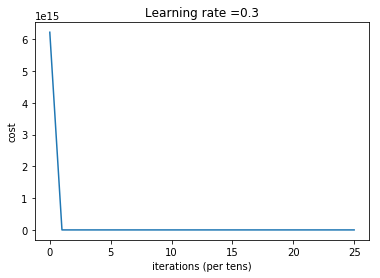


Validation cost = 7.6587477


In [55]:
# Initialize all the variables globally
init = tf.global_variables_initializer()

# start the session
sess = tf.Session()

# Run the initialization
sess.run(init)

# run the model train the parameters
parameter, Y_val_pred, Y_test_pred = minimize_model(X_train, Y_train, X_val, Y_val,
                           graph, sess, num_epochs=26, minibatch_size=32, print_cost=True)

# close the session
sess.close()

1.predicted landmarks vs 2.labeled landmarks


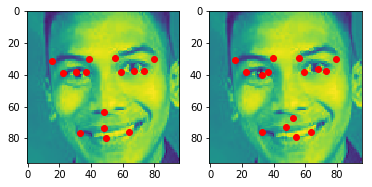

In [56]:
n1 = 105
n2 = val_idx[n1]

# Separate x and y axes cords into different lists
cord_x_pred = []
cord_y_pred = []
cord_x = []
cord_y = []
#data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAXwAAAEWCAYAAABliCz2AAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMi4yLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvhp/UCwAAGvJJREFUeJzt3X2UZHV95/H3p7tqpgqmiwfpEHSAQaKia0RwhLAgixg9osRHMBo1YNyMuOIaY45R16Mku+xhRQwaY8KoPHgEFEEMzhoUXXlSeehBQGBEFEFAYJoHmRmcp+757h/3Vk9NT1V19Uzfru77+7zOqdPVt2/d3+9Owad//bu3vj9FBGZmVn4D/e6AmZnNDge+mVkiHPhmZolw4JuZJcKBb2aWCAe+mVkiHPhWKpL+Q9JJ/e6H2VzkwLcZIek+SX/a735ExHERcUG/+wEg6WpJ/3UW2lko6VxJayQ9Iulvu+z7Vkl3S3pK0mpJF0hqFN1Hmxsc+DZvSKr0uw9Nc6kvwGnAc4D9gZcDH5b06g77/gg4MiJ2A54NVID/NRudtP5z4FvhJB0v6VZJv5P0Y0kvavnZRyT9StJaSXdJemPLz06W9CNJ/yTpceC0fNv1kj4t6UlJv5Z0XMtrJkbVPex7gKRr87a/L+lfJH21wzkcI+lBSX8v6RHgPEl7SFohaTQ//gpJi/P9TwdeBnxe0jpJn8+3HyTpKklP5CPtt8zAP/FJwP+MiCcjYhXwReDkdjtGxAMR8VjLpnHgj2agDzYPOPCtUJIOAc4F3gM8AzgHuELSwnyXX5EF427APwBflbRPyyEOB+4F9gZOb9l2N7AX8Cngy5LUoQvd9r0IuCnv12nAO6c4nT8E9iQbSS8j+//nvPz7/YD1wOcBIuJ/ANcBp0bEoog4VdKuwFV5u38AvBX4gqQXtGtM0hfyX5LtHrfn++wB7APc1vLS24D/1OkkJB0l6SlgLfBm4OwpzttKYs4Ffj4XuVrSHT3se7SkWySNSTph0s/G81HlrZKuKK7HNoVlwDkRcWNEjOfz6xuBPwGIiG9ExG8jYktEfB24Bzis5fW/jYh/joixiFifb7s/Ir4YEePABWSBt3eH9tvuK2k/4KXAJyJiU0RcD0z138kW4JMRsTEi1kfE4xFxWUT8PiLWkv1C+i9dXn88cF9EnJefz0+By4AT2+0cEf8tInbv8Gj+lbQo//pUy0ufAoY6dSIirs+ndBYDZwL3TXHeVhJzLvCB84FO84+T/YbsT9eL2vxsfUS8OH+8bob6ZtO3P/Ch1tEpsC/wTABJf9ky3fM74IVko/GmB9oc85Hmk4j4ff50UZv9uu37TOCJlm2d2mo1GhEbmt9I2kXSOZLul7QGuBbYXdJgh9fvDxw+6d/i7WR/OeyodfnX1guvDbLRe1cR8RBwJfC1nWjf5pE5F/gRcS3wROs2SQdKulLSSknXSToo3/e+iLidbORlc9MDwOmTRqe7RMTFkvYnm28+FXhGROwO3AG0Ts8UVc71YWBPSbu0bNt3itdM7suHgOcBh0dEAzg6364O+z8AXDPp32JRRLy3XWOS/i2f/2/3uBMgIp7Mz+XglpceDNw5xbk0VYADe9zX5rk5F/gdLAfeHxEvAf4O+EIPr6lJGpF0g6Q3FNs9y1Ul1VoeFbJAP0XS4crsKum1koaAXclCcRRA0rvIRviFi4j7gRGyC8ELJB0B/Nk0DzNENm//O0l7Ap+c9PNHye6EaVoBPFfSOyVV88dLJT2/Qx9PyX8htHu0ztF/Bfh4fhH5IOCvyf5S3o6kt+fTWeS/cE8HfjDN87Z5as4HvqRFwH8GviHpVrKLfvt0fxUA+0fEUuAvgLMleRRTvO+QBWDzcVpEjJAF0OeBJ4Ffkt9BEhF3AWcBPyELxz8mu21wtrwdOAJ4nOzWxK+TXV/o1dlAHXgMuIFseqTVZ4ET8jt4PpfP87+K7GLtb8mmm/4PsJCd80myi9/3A9cAZ0bElQCS9sv/Itgv3/cFwI8lPU32b3032ftjCdBcXABF0hJgRUS8UNmHQu6OiI4hL+n8fP9Ld+TnZgCSvg78PCImj9TNSmHOj/AjYg3wa0knAuTTAgd3e03+p+3C/PlewJHAXYV31uaVfDrlQEkDyj6o9HrgW/3ul1lR5lzgS7qY7E/85yn7oMu7yf70frek28guRr0+3/elkh4ku63tnOaFLOD5wEi+/w+BM/LpA7NWfwhcTXany+eA9+a3SpqV0pyc0jEzs5k350b4ZmZWjLlUAIq99torlixZ0u9umJnNGytXrnwsIoZ72XdOBf6SJUsYGRnpdzfMzOYNSff3uq+ndMzMEuHANzNLhAPfzCwRDnwzs0Q48M3MEuHANzNLhAPfzCwRpQj8f/7BPVzzi9F+d8PMbE4rReCfc+29XHO3A9/MrJtSBH6jVmHNhs397oaZ2ZxWjsCvV1mz3oFvZtZNOQK/VmXthrF+d8PMbE4rNPAl7S7pUkk/l7QqXyh6xjXqntIxM5tK0SP8zwJXRsRBwMHAqiIaGapVHfhmZlMorDyypN2Ao4GTASJiE7CpiLYatQpr1ntKx8ysmyJH+AcAo8B5kn4q6UuSdp28k6RlkkYkjYyO7titlY16lbUbNuPlGs3MOisy8CvAocC/RsQhwNPARybvFBHLI2JpRCwdHu5p0ZbtNGpVtgQ8vWl8pzpsZlZmRQb+g8CDEXFj/v2lZL8AZtxQLZuZ8q2ZZmadFRb4EfEI8ICk5+WbXgHcVURbjXoVwBduzcy6KHpN2/cDF0paANwLvKuIRhq1PPB94dbMrKNCAz8ibgWWFtkGZPfhA6z1CN/MrKNSfNJ2qOYpHTOzqZQi8BsTF209pWNm1kkpAn9ihO+7dMzMOipF4C+oDFCvDrJ2o0f4ZmadlCLwIbsX3yN8M7POShP4jboLqJmZdVOewHcBNTOzrsoT+HkBNTMza688gV+rssarXpmZdVSawPdFWzOz7koT+M2Ltq6Jb2bWXnkCv1Zl83iwYfOWfnfFzGxOKk/gu4CamVlXpQl8F1AzM+uuNIHfLKD2lO/FNzNrqzyB71WvzMy6Kk/g51M6a30vvplZWyUKfC9kbmbWTXkC31M6ZmZdlSbwF1YGWDA44AJqZmYdlCbwJdGoV3wfvplZB6UJfMjuxXcBNTOz9koV+A0XUDMz66hS5MEl3QesBcaBsYhYWmR7XvXKzKyzQgM/9/KIeGwW2qFRq/LwUxtmoykzs3mnXFM6dU/pmJl1UnTgB/A9SSslLWu3g6RlkkYkjYyOju5UY9lFWwe+mVk7RQf+URFxKHAc8D5JR0/eISKWR8TSiFg6PDy8U401ahU2bN7CxrHxnTqOmVkZFRr4EfFQ/nU1cDlwWJHtNT9t63o6ZmbbKyzwJe0qaaj5HHgVcEdR7YELqJmZdVPkXTp7A5dLarZzUURcWWB7DLmAmplZR4UFfkTcCxxc1PHbcQE1M7POynVbZnOZQxdQMzPbTrkC3wuZm5l1VKrA90LmZmadlSrwd10wyIA8pWNm1k6pAj+rie9P25qZtVOqwIfswq3vwzcz217pAn/INfHNzNoqXeA3XEDNzKyt8gV+veKLtmZmbZQv8GtV34dvZtZG+QK/7oXMzczaKV3gD9UqrNs4xtj4ln53xcxsTild4Dfr6azb6FG+mVmr8gV+3QXUzMzaKV/gN2vi+8Ktmdk2Shf4LqBmZtZe6QK/WSLZUzpmZtsqX+B7hG9m1lb5Ar/uhczNzNopXeAvWuiFzM3M2ild4A8OiKGFFU/pmJlNUrrAh7y8gi/amplto5SBP1SruICamdkkhQe+pEFJP5W0oui2mlwT38xse7Mxwv8AsGoW2pngmvhmZtsrNPAlLQZeC3ypyHYm8wjfzGx7RY/wzwY+DHSsVSxpmaQRSSOjo6Mz0mij7oXMzcwmKyzwJR0PrI6Ild32i4jlEbE0IpYODw/PSNuN/KLtli0xI8czMyuDIkf4RwKvk3Qf8DXgWElfLbC9CUO1KlsCnt7kUb6ZWVNhgR8RH42IxRGxBHgr8P8i4h1FtddqooCap3XMzCaU8j78iQJqLq9gZjahMhuNRMTVwNWz0Ra4gJqZWTulHOEP1VxAzcxsslIGvmvim5ltr5yBX/ccvpnZZKUM/OaUjufwzcy2KmXgVwcHqFcHPaVjZtailIEPLqBmZjZZeQPfBdTMzLZR3sB3ATUzs22UNvCHal7X1sysVWkDv1Gr+rZMM7MW5Q38esXF08zMWpQ38GtV1m7YTIRr4puZQZkDv15l83iwYXPHxbbMzJJS2sCfKKDmC7dmZkCPgS/pxF62zSWuiW9mtq1eR/gf7XHbnDFRQM0jfDMzYIoFUCQdB7wGeJakz7X8qAHM6VtgGjUvc2hm1mqqFa9+C4wArwNWtmxfC3ywqE7NhCFP6ZiZbaNr4EfEbcBtki6KiM0AkvYA9o2IJ2ejgzvKC5mbmW2r1zn8qyQ1JO0J3AJ8UdI/FdivneaLtmZm2+o18HeLiDXAm4CvRMThwCuK69bOq1UHWVAZcAE1M7Ncr4FfkbQP8BZgRYH9mVENF1AzM5vQa+D/I/Bd4FcRcbOkZwP3dHuBpJqkmyTdJulOSf+ws52dLhdQMzPbaqq7dACIiG8A32j5/l7gzVO8bCNwbESsk1QFrpf0HxFxww73dpqG6lVftDUzy/X6SdvFki6XtDp/XCZpcbfXRGZd/m01f8xqJbNGrcJaT+mYmQG9T+mcB1wBPDN/fDvf1pWkQUm3AquBqyLixh3t6I7wlI6Z2Va9Bv5wRJwXEWP543xgeKoXRcR4RLwYWAwcJumFk/eRtEzSiKSR0dHRaXV+Kq6Jb2a2Va+B/7ikd+Qj9kFJ7wAe77WRiPgd8EPg1W1+tjwilkbE0uHhKX+HTItH+GZmW/Ua+H9FdkvmI8DDwAnAyd1eIGlY0u758zrwSuDnO9zTHdCoV9k4toWNY+Oz2ayZ2ZzU0106ZLdlntQsp5B/4vbTZL8IOtkHuEDSINkvlksiYlbv4W8WUFu7YYyFiwZns2kzszmn18B/UWvtnIh4QtIh3V4QEbcDXfcpWmsBtb0WLexnV8zM+q7XKZ2BvGgaMDHC7/WXRd+4gJqZ2Va9hvZZwE8kNT98dSJwejFdmjkuoGZmtlWvn7T9iqQR4Nh805si4q7iujUzmqteuYCamdk0pmXygJ/zId/KC5mbmW3V6xz+vOQpHTOzrUod+LssGGRwQB7hm5lR8sCXlBdQ8xy+mVmpAx+ye/E9pWNmlkDgu4CamVmm/IHvEb6ZGZBI4HsO38wsgcAf8kLmZmZAAoHfqHtKx8wMUgj8WpWnN40zNr6l310xM+ur8gd+XjFz3UbP45tZ2sof+BPlFRz4Zpa20ge+C6iZmWVKH/jNEsm+cGtmqSt/4DendDzCN7PElT/wvcyhmRmQQOAPuSa+mRmQQuAvrCB5hG9mVvrAHxgQixZWPMI3s+QVFviS9pX0Q0l3SbpT0geKamsqLqBmZjaNRcx3wBjwoYi4RdIQsFLSVfli6LPKBdTMzAoc4UfEwxFxS/58LbAKeFZR7XXjAmpmZrM0hy9pCXAIcGObny2TNCJpZHR0tJD2G7WqL9qaWfIKD3xJi4DLgL+JiDWTfx4RyyNiaUQsHR4eLqQPjXqFtZ7SMbPEFRr4kqpkYX9hRHyzyLa68TKHZmbF3qUj4MvAqoj4TFHt9KJRq7B24xhbtkQ/u2Fm1ldFjvCPBN4JHCvp1vzxmgLb66hRrxIB6zZ5Ht/M0lXYbZkRcT2goo4/Hc0Cams3jE08NzNLTek/aQstBdQ8j29mCUsi8F1AzcwskcDfWhPfc/hmlq40At9TOmZmiQT+xEVbB76ZpSuJwF9U86pXZmZJBH51cIBdFgx6SsfMkpZE4EOzgJoD38zSlU7g1yteBMXMkpZM4A95hG9miUsm8Bu1CmvWe4RvZulKJ/DrHuGbWdrSCXwvZG5miUsm8IdqFdas30yEa+KbWZqSCfxGvcrYlmD95vF+d8XMrC/SCfyJipme1jGzNKUT+HkBNdfTMbNUpRP4EyWSHfhmlqZkAn+oWUDNUzpmlqhkAr9R9wjfzNKWTuB7mUMzS1wygT/kmvhmlrhkAr9WHWRBZcBTOmaWrMICX9K5klZLuqOoNqarUav6oq2ZJavIEf75wKsLPP60NeoVj/DNLFmFBX5EXAs8UdTxd4QLqJlZyvo+hy9pmaQRSSOjo6OFttUsoGZmlqK+B35ELI+IpRGxdHh4uNC2XBPfzFLW98CfTb5oa2YpSyvw6xUXTzOzZBV5W+bFwE+A50l6UNK7i2qrV41alY1jW9jgmvhmlqBKUQeOiLcVdewd1ag1SySPUasO9rk3ZmazK7EpHRdQM7N0pRX4eQE134tvZilKK/DrzZr4HuGbWXqSCvwhr3plZglLKvC9kLmZpSytwG9O6XiEb2YJSirw69VBKgPyh6/MLElJBb6kvICap3TMLD1JBT64gJqZpSu9wK9VfVummSUpvcCvV/zBKzNLUnKBP7TQUzpmlqbkAr9R90VbM0tTeoFf8wjfzNKUXuDXq/x+0zhj41v63RUzs1mVXOAPtdTENzNLSXKB33ABNTNLVHqBX3cBNTNLU3qBPzGl4xG+maUlvcD3ModmlqjkAr950dZTOmaWmuQC3yN8M0tVcoG/aEEFyevamll6Cg18Sa+WdLekX0r6SJFt9WpgQAwtrLDG9+GbWWIKC3xJg8C/AMcBLwDeJukFRbU3HUMur2BmCaoUeOzDgF9GxL0Akr4GvB64q8A2e9KoV/nenY/yys9c0++umJmxxy4LuOSUIwpvp8jAfxbwQMv3DwKHT95J0jJgGcB+++1XYHe2+uuXHcD3Vz06K22ZmU2lWQGgaEUGfk8iYjmwHGDp0qUxG22+6dDFvOnQxbPRlJnZnFHkRduHgH1bvl+cbzMzsz4oMvBvBp4j6QBJC4C3AlcU2J6ZmXVR2JRORIxJOhX4LjAInBsRdxbVnpmZdVfoHH5EfAf4TpFtmJlZb5L7pK2ZWaoc+GZmiXDgm5klwoFvZpYIRczKZ516ImkUuH8HX74X8NgMdmc+8DmXX2rnCz7n6do/IoZ72XFOBf7OkDQSEUv73Y/Z5HMuv9TOF3zORfKUjplZIhz4ZmaJKFPgL+93B/rA51x+qZ0v+JwLU5o5fDMz665MI3wzM+vCgW9mloh5H/hzcaH0okm6T9LPJN0qaaTf/SmCpHMlrZZ0R8u2PSVdJeme/Ose/ezjTOtwzqdJeih/r2+V9Jp+9nGmSdpX0g8l3SXpTkkfyLeX9r3ucs6Fv9fzeg4/Xyj9F8AryZZQvBl4W0T0fd3cIkm6D1gaEaX9cIqko4F1wFci4oX5tk8BT0TEGfkv9z0i4u/72c+Z1OGcTwPWRcSn+9m3okjaB9gnIm6RNASsBN4AnExJ3+su5/wWCn6v5/sIf2Kh9IjYBDQXSrd5LiKuBZ6YtPn1wAX58wvI/icpjQ7nXGoR8XBE3JI/XwusIlsPu7TvdZdzLtx8D/x2C6XPyj9cnwXwPUkr80XgU7F3RDycP38E2LufnZlFp0q6PZ/yKc3UxmSSlgCHADeSyHs96Zyh4Pd6vgd+qo6KiEOB44D35VMBSYlsLnL+zkf27l+BA4EXAw8DZ/W3O8WQtAi4DPibiFjT+rOyvtdtzrnw93q+B36SC6VHxEP519XA5WRTWyl4NJ//bM6Dru5zfwoXEY9GxHhEbAG+SAnfa0lVsuC7MCK+mW8u9Xvd7pxn472e74Gf3ELpknbNL/QgaVfgVcAd3V9VGlcAJ+XPTwL+vY99mRXN0Mu9kZK915IEfBlYFRGfaflRad/rTuc8G+/1vL5LByC/delsti6Ufnqfu1QoSc8mG9VDtibxRWU8Z0kXA8eQlY19FPgk8C3gEmA/sjLab4mI0lzk7HDOx5D9iR/AfcB7Wua25z1JRwHXAT8DtuSbP0Y2p13K97rLOb+Ngt/reR/4ZmbWm/k+pWNmZj1y4JuZJcKBb2aWCAe+mVkiHPhmZolw4FvhJP04/7pE0l/M8LE/1q6tokh6g6RPFHTsj02917SP+ceSzp/p49r85NsybdZIOgb4u4g4fhqvqUTEWJefr4uIRTPRvx7782PgdTtbqbTdeRV1LpK+D/xVRPxmpo9t84tH+FY4Sevyp2cAL8trfX9Q0qCkMyXdnBeMek++/zGSrpN0BXBXvu1bebG4O5sF4ySdAdTz413Y2pYyZ0q6Q9naAX/ecuyrJV0q6eeSLsw/+YikM/Ia5bdL2q5EraTnAhubYS/pfEn/JmlE0i8kHZ9v7/m8Wo7d7lzeIemmfNs5eTlwJK2TdLqk2yTdIGnvfPuJ+fneJunalsN/m+xT6Ja6iPDDj0IfZDW+IfvU6IqW7cuAj+fPFwIjwAH5fk8DB7Tsu2f+tU72kfNntB67TVtvBq4i+wT23sBvgH3yYz9FVndpAPgJcBTwDOButv7Vu3ub83gXcFbL9+cDV+bHeQ5ZtdbadM6rXd/z588nC+pq/v0XgL/MnwfwZ/nzT7W09TPgWZP7DxwJfLvf/x340f9HpddfDGYFeBXwIkkn5N/vRhacm4CbIuLXLfv+d0lvzJ/vm+/3eJdjHwVcHBHjZIW4rgFeCqzJj/0ggKRbgSXADcAG4MuSVgAr2hxzH2B00rZLIit2dY+ke4GDpnlenbwCeAlwc/4HSJ2tBcQ2tfRvJdkCQAA/As6XdAnwza2HYjXwzB7atJJz4Fs/CXh/RHx3m43ZXP/Tk77/U+CIiPi9pKvJRtI7amPL83GgEhFjkg4jC9oTgFOBYye9bj1ZeLeafBEs6PG8piDggoj4aJufbY6IZrvj5P8fR8Qpkg4HXguslPSSiHic7N9qfY/tWol5Dt9m01pgqOX77wLvzUvFIum5eQXQyXYDnszD/iDgT1p+trn5+kmuA/48n08fBo4GburUMWW1yXeLiO8AHwQObrPbKuCPJm07UdKApAOBZ5NNC/V6XpO1nssPgBMk/UF+jD0l7d/txZIOjIgbI+ITZH+JNEuHP5eSVdm0HeMRvs2m24FxSbeRzX9/lmw65Zb8wuko7ZeyuxI4RdIqskC9oeVny4HbJd0SEW9v2X45cARwG9mo+8MR8Uj+C6OdIeDfJdXIRtd/22afa4GzJKllhP0bsl8kDeCUiNgg6Us9ntdk25yLpI+TrWw2AGwG3kdWObKTMyU9J+//D/JzB3g58H97aN9Kzrdlmk2DpM+SXQD9fn5/+4qIuLTP3epI0kLgGrJV0jre3mpp8JSO2fT8b2CXfndiGvYDPuKwN/AI38wsGR7hm5klwoFvZpYIB76ZWSIc+GZmiXDgm5kl4v8DfxsBTXIVF7sAAAAASUVORK5CYII=
for i in range(15):
    cord_x_pred.append(Y_val_pred[n1, 2*i])
    cord_y_pred.append(Y_val_pred[n1, 2*i + 1])
    cord_x.append(Y_val[n1, 2*i])
    cord_y.append(Y_val[n1, 2*i + 1])
    
_, ax = plt.subplots(1, 2)

## plot predicted landmarks
ax[0].imshow(images[n2])
ax[0].scatter(cord_x_pred, cord_y_pred, color='red')

# plot labeled landmarks
ax[1].imshow(images[n2])
ax[1].scatter(cord_x, cord_y, color='red')
print('1.predicted landmarks vs 2.labeled landmarks')

Going one layer deep also has no effect on the validation cost, so let's increase the batch size

In [57]:
graph = model_graph(X_train, Y_train, parameter_dims = [[4, 4, 1, 4], [4, 4, 4, 16],
                                           [2, 2, 16, 32], [2, 2, 32, 64], [2, 2, 64, 128]], 
                                                                             pool_frequency = 1,
                                                                             learning_rate=0.1)

Cost after epoch 0: 1121.172742
Cost after epoch 5: 5.860436
Cost after epoch 10: 5.860436
Cost after epoch 15: 5.860436
Cost after epoch 20: 5.860436


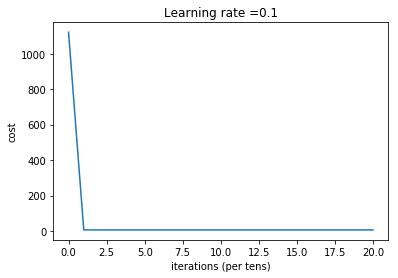


Validation cost = 7.546961


In [58]:
# Initialize all the variables globally
init = tf.global_variables_initializer()

# start the session
sess = tf.Session()

# Run the initialization
sess.run(init)

# run the model train the parameters
parameter, Y_val_pred, Y_test_pred = minimize_model(X_train, Y_train, X_val, Y_val,
                           graph, sess, num_epochs=21, minibatch_size=64, print_cost=True)

# close the session
sess.close()

1.predicted landmarks vs 2.labeled landmarks


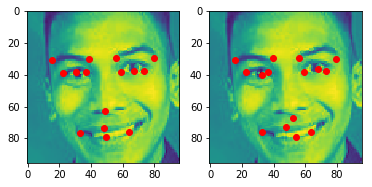

In [59]:
n1 = 105
n2 = val_idx[n1]

# Separate x and y axes cords into different lists
cord_x_pred = []
cord_y_pred = []
cord_x = []
cord_y = []

for i in range(15):
    cord_x_pred.append(Y_val_pred[n1, 2*i])
    cord_y_pred.append(Y_val_pred[n1, 2*i + 1])
    cord_x.append(Y_val[n1, 2*i])
    cord_y.append(Y_val[n1, 2*i + 1])
    
_, ax = plt.subplots(1, 2)

## plot predicted landmarks
ax[0].imshow(images[n2])
ax[0].scatter(cord_x_pred, cord_y_pred, color='red')

# plot labeled landmarks
ax[1].imshow(images[n2])
ax[1].scatter(cord_x, cord_y, color='red')
print('1.predicted landmarks vs 2.labeled landmarks')

Seems the training set is over-fitting, lets add dropout regularization

In [62]:
graph = model_graph(X_train, Y_train, parameter_dims = [[4, 4, 1, 4], [4, 4, 4, 16],
                                           [2, 2, 16, 32], [2, 2, 32, 64], [2, 2, 64, 128]], 
                    pool_frequency = 1,    
                    learning_rate=0.1,
                    keep_prob=0.75
                   )

Cost after epoch 0: 33130849550.515884
Cost after epoch 5: 5.860436
Cost after epoch 10: 5.860436
Cost after epoch 15: 5.860436
Cost after epoch 20: 5.860436


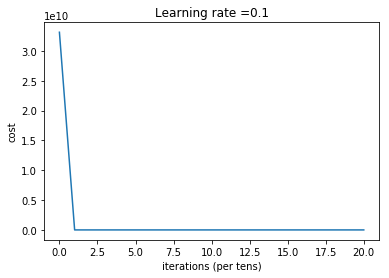


Validation cost = 7.546961


In [63]:
# Initialize all the variables globally
init = tf.global_variables_initializer()

# start the session
sess = tf.Session()

# Run the initialization
sess.run(init)

# run the model train the parameters
parameter, Y_val_pred, Y_test_pred = minimize_model(X_train, Y_train, X_val, Y_val,
                           graph, sess, num_epochs=21, minibatch_size=64, print_cost=True)

# close the session
sess.close()

1.predicted landmarks vs 2.labeled landmarks


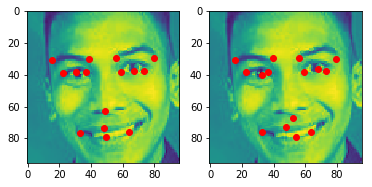

In [65]:
n1 = 105
n2 = val_idx[n1]

# Separate x and y axes cords into different lists
cord_x_pred = []
cord_y_pred = []
cord_x = []
cord_y = []

for i in range(15):
    cord_x_pred.append(Y_val_pred[n1, 2*i])
    cord_y_pred.append(Y_val_pred[n1, 2*i + 1])
    cord_x.append(Y_val[n1, 2*i])
    cord_y.append(Y_val[n1, 2*i + 1])
    
_, ax = plt.subplots(1, 2)

## plot predicted landmarks
ax[0].imshow(images[n2])
ax[0].scatter(cord_x_pred, cord_y_pred, color='red')

# plot labeled landmarks
ax[1].imshow(images[n2])
ax[1].scatter(cord_x, cord_y, color='red')
print('1.predicted landmarks vs 2.labeled landmarks')

Lets reduce the minibatch size and see

In [66]:
graph = model_graph(X_train, Y_train, parameter_dims = [[4, 4, 1, 4], [4, 4, 4, 16],
                                           [2, 2, 16, 32], [2, 2, 32, 64], [2, 2, 64, 128]], 
                                                                             pool_frequency = 1,
                                                                             learning_rate=0.1)

Cost after epoch 0: 8420.638247
Cost after epoch 5: 5.060323
Cost after epoch 10: 5.060323
Cost after epoch 15: 5.125229
Cost after epoch 20: 5.119562


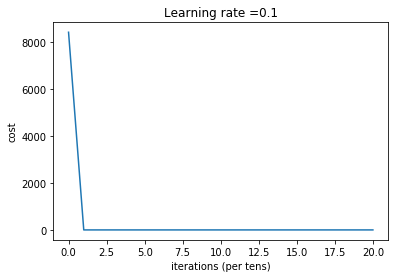


Validation cost = 7.738833


In [67]:
# Initialize all the variables globally
init = tf.global_variables_initializer()

# start the session
sess = tf.Session()

# Run the initialization
sess.run(init)

# run the model train the parameters
parameter, Y_val_pred, Y_test_pred = minimize_model(X_train, Y_train, X_val, Y_val,
                           graph, sess, num_epochs=21, minibatch_size=16, print_cost=True)

# close the session
sess.close()

1.predicted landmarks vs 2.labeled landmarks


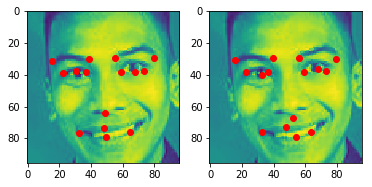

In [68]:
n1 = 105
n2 = val_idx[n1]

# Separate x and y axes cords into different lists
cord_x_pred = []
cord_y_pred = []
cord_x = []
cord_y = []

for i in range(15):
    cord_x_pred.append(Y_val_pred[n1, 2*i])
    cord_y_pred.append(Y_val_pred[n1, 2*i + 1])
    cord_x.append(Y_val[n1, 2*i])
    cord_y.append(Y_val[n1, 2*i + 1])
    
_, ax = plt.subplots(1, 2)

## plot predicted landmarks
ax[0].imshow(images[n2])
ax[0].scatter(cord_x_pred, cord_y_pred, color='red')

# plot labeled landmarks
ax[1].imshow(images[n2])
ax[1].scatter(cord_x, cord_y, color='red')
print('1.predicted landmarks vs 2.labeled landmarks')

### 5.2. Let's choose the model with smallest validation cost

In [100]:
#applying the same string-to-matrix 
images_test = test_data['Image'].values

images_test = to_image(images_test)

X_test = images_test[:, :, :, np.newaxis]



#plt.imshow(images_test[43])


In [86]:
graph = model_graph(X_train, Y_train, parameter_dims = [[4, 4, 1, 4], [4, 4, 4, 16],
                                           [2, 2, 16, 32], [2, 2, 32, 64], [2, 2, 64, 128]], 
                    pool_frequency = 1,    
                    learning_rate=0.1,
                    keep_prob=0.75
                   )

Cost after epoch 0: 257907.596554
Cost after epoch 5: 5.860436
Cost after epoch 10: 5.860436
Cost after epoch 15: 5.860436
Cost after epoch 20: 5.860436


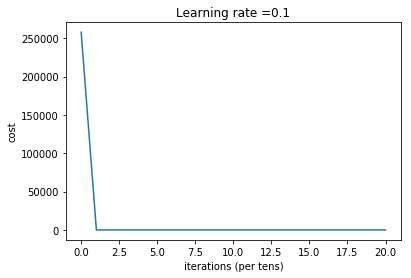


Validation cost = 7.546961


In [88]:
# Initialize all the variables globally
init = tf.global_variables_initializer()

# start the session
sess = tf.Session()

# Run the initialization
sess.run(init)

# run the model train the parameters
parameter, Y_val_pred, Y_test_pred = minimize_model(X_train, Y_train, X_val, Y_val,
                           graph, sess,  X_test=X_test, num_epochs=21, minibatch_size=64, print_cost=True)

# close the session
sess.close()

In [84]:
#checking the shape of the images in the test set 
images_test.shape

(1783, 96, 96, 1)

predicted landmarks


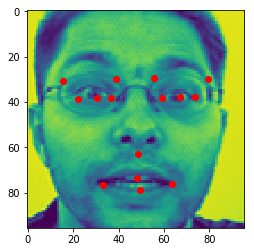

In [92]:
n1 = 0

# Separate x and y axes cords into different lists
cord_x_pred = []
cord_y_pred = []


for i in range(15):
    cord_x_pred.append(Y_test_pred[n1, 2*i])
    cord_y_pred.append(Y_test_pred[n1, 2*i + 1])

plt.imshow(images_test[n1])
plt.scatter(cord_x_pred, cord_y_pred, color='red')

print('predicted landmarks')

## Testing and Validation

Now lets prepare our testing data. As image column values are in string format and there is also some missing values so we have to split the string by space and append it and also handling missing values

In [9]:
#viewing our test data
test_data.head().T

,0,1,2,3,4
ImageId,1,2,3,4,5
Image,182 183 182 182 180 180 176 169 156 137 124 10...,76 87 81 72 65 59 64 76 69 42 31 38 49 58 58 4...,177 176 174 170 169 169 168 166 166 166 161 14...,176 174 174 175 174 174 176 176 175 171 165 15...,50 47 44 101 144 149 120 58 48 42 35 35 37 39 ...


In [13]:
#preparing test data
timag = []
for i in range(0,1783):
    timg = test_data['Image'][i].split(' ')
    timg = ['0' if x == '' else x for x in timg]
    
    timag.append(timg)

In [14]:
#converting the test data into numpy array for better data handling
timage_list = np.array(timag,dtype = 'float')
X_test = timage_list.reshape(-1,96,96)

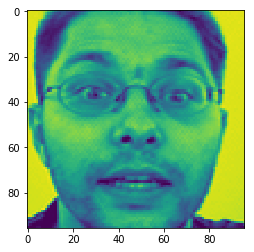

In [15]:
#plotting a sample image from the test dataset
plt.imshow(X_test[0])
plt.show()

The predictions are already saved in 'Y_test_pred'. We just need it to the required format.

Now the last step is the create our submission file keeping in the mind required format. There should be two columns :- RowId and Location Location column values should be filled according the lookup table provided ( IdLookupTable.csv)

In [108]:
#using the FeatureName, RowID and ImageId column from the IdLookupTable 
lookid_list = list(lookid_data['FeatureName'])
imageID = list(lookid_data['ImageId']-1)
pre_list = list(Y_test_pred)
rowid = lookid_data['RowId']
rowid=list(rowid)

#formatting for better handling
feature = []
for f in list(lookid_data['FeatureName']):
    feature.append(lookid_list.index(f))


preded = []
for x,y in zip(imageID,feature):
    preded.append(pre_list[x][y])


In [109]:
#converting data into Series
rowid = pd.Series(rowid,name = 'RowId')
loc = pd.Series(preded,name = 'Location')

#appending predicted key-points with image ID
submission = pd.concat([rowid,loc],axis = 1)

#saving the predictions to a csv file to upload in Kaggle
submission.to_csv('face_key_detection_submission.csv',index = False)